Подключение к Google Drive

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Библиотеки

In [4]:
import os
import json
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb

# Работа с данными

Пути и параметры

In [5]:
dir_google_drive = "/content/drive/MyDrive/Neural Network"
train_data = "Dataset/images_train_test_val/train"
valid_data = "Dataset/images_train_test_val/validation"
test_data = "Dataset/images_train_test_val/test"
full_data = "Dataset/images"

seed = 123
batch_size = 32
img_height = 224
img_width = 224

Загрузка сета и меток

In [6]:
def load_dataset(dir, size, batch_size, seed, label_mode):
    return keras.utils.image_dataset_from_directory(dir,
                                                    image_size=size,
                                                    batch_size=batch_size,
                                                    seed=seed,
                                                    label_mode=label_mode
                                                    )


def load_label(filename):
    with open(os.path.join(dir_google_drive, filename)) as f:
        templates = json.load(f)
    label = np.array([item[0] for item in templates.items()])
    return label


def get_label(dataset):
    return np.array(dataset.class_names)

Вывод исходных данных

In [7]:
def print_table(data, index, columns):
    table = pd.DataFrame(data=data,
                         index=index,
                         columns=columns)
    print(table)

Загрузка датасета

In [8]:
train_ds = load_dataset(os.path.join(dir_google_drive, train_data),
                        size=(img_height, img_width),
                        batch_size=batch_size,
                        seed=seed,
                        label_mode="categorical")
valid_ds = load_dataset(os.path.join(dir_google_drive, valid_data),
                        size=(img_height, img_width),
                        batch_size=batch_size,
                        seed=seed,
                        label_mode="categorical")
test_ds = load_dataset(os.path.join(dir_google_drive, test_data),
                       size=(img_height, img_width),
                       batch_size=batch_size,
                       seed=seed3,
                       label_mode="categorical")

Found 7350 files belonging to 21 classes.
Found 2100 files belonging to 21 classes.
Found 1050 files belonging to 21 classes.


In [9]:
def print_table(data, index, columns):
    table = pd.DataFrame(data=data,
                         index=index,
                         columns=columns)
    print(table)

In [10]:
class_names = np.array(load_label('Dataset/label_map.json'))
class_count = len(class_names)
print_table(data=class_names,
            index=np.array([i for i in range(1, class_count + 1)]),
            columns=['Class name'])

           Class name
1        agricultural
2            airplane
3     baseballdiamond
4               beach
5           buildings
6           chaparral
7    denseresidential
8              forest
9             freeway
10         golfcourse
11       intersection
12  mediumresidential
13     mobilehomepark
14           overpass
15         parkinglot
16              river
17             runway
18  sparseresidential
19       storagetanks
20        tenniscourt
21             harbor


In [11]:
def draw_example_image(rows, cols, dataset, class_names):
    plt.figure(figsize=(rows * 4, cols * 4))
    for images, labels in dataset.take(1):
        for i in range(rows * cols):
            ax = plt.subplot(rows, cols, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[tf.argmax(labels[i])])
            plt.axis("off")


def get_lables_count(path):
    dirs = np.array([list(os.walk(path))])
    labels_count = []
    for folders in dirs:
        for files in folders:
            labels_count.append(len(files[2]))

    labels_count.pop(0)
    return labels_count


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


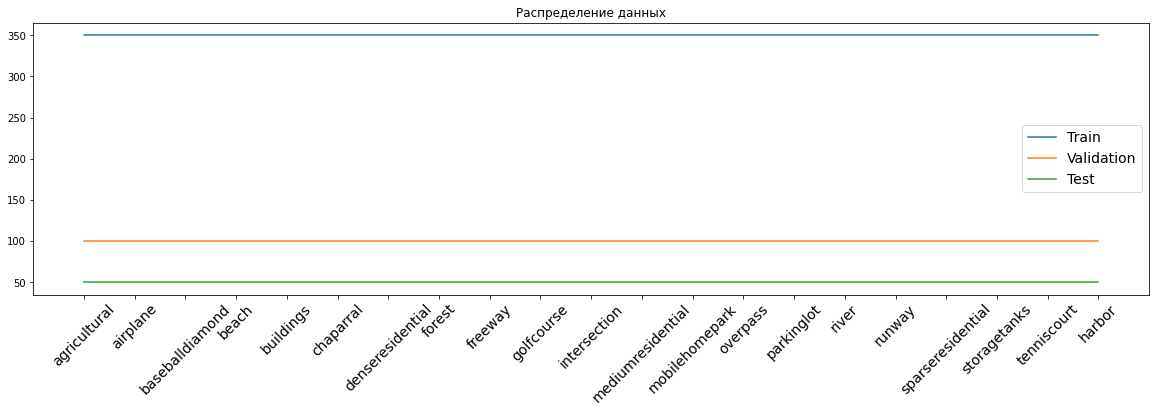

In [12]:
test = get_lables_count(os.path.join(dir_google_drive, test_data))
valid = get_lables_count(os.path.join(dir_google_drive, valid_data))
train = get_lables_count(os.path.join(dir_google_drive, train_data))

plt.figure(figsize=(20, 5))
plt.title('Распределение данных')
plt.plot(class_names, train, '-', class_names, valid, '-', class_names, test, '-')
plt.xticks(rotation=45, fontsize=14)
plt.legend(['Train', 'Validation', 'Test'], fontsize=14)

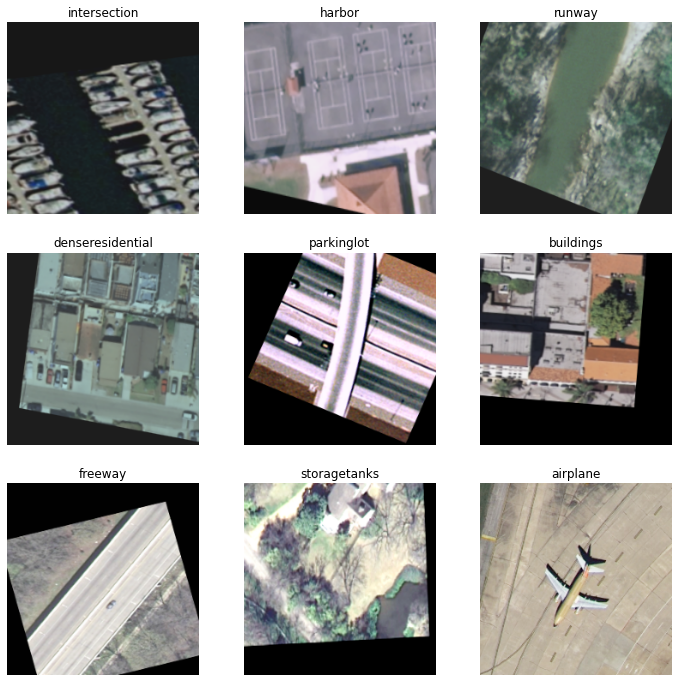

In [13]:
draw_example_image(3, 3, train_ds, class_names)

# Графики

In [15]:
def draw_accuracy(history):
    fig = plt.figure(figsize=(10, 5))
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model Accuracy', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.xlabel('Epochs', fontsize=14)
    plt.legend(['Train', 'Validation'], fontsize=14)


def draw_matrix(matrix, size, labels_x=[], labels_y=[], mask=None, line=0., cmap='inferno', line_color='black'):
    vmax = np.max(matrix)
    if vmax < 1:
        vmax = 1

    plt.figure(figsize=(size))
    ax = sb.heatmap(matrix,
                    annot=True,
                    vmin=0,
                    vmax=vmax,
                    mask=mask,
                    fmt='.5g',
                    cmap=cmap,
                    linewidths=line,
                    linecolor=line_color,
                    annot_kws={'fontsize'=14})

    if labels_y != []:
        ax.set_yticklabels(labels_y,
                           fontsize=14,
                           rotation=0,
                           verticalalignment='center')
    if labels_x != []:
        ax.set_xticklabels(labels_x,
                           fontsize=14,
                           rotation=45,
                           horizontalalignment='center')
        plt.show()

# Оценка моделей

In [16]:
# TruePositive
def TP(matrix):
    return np.diag(matrix)


# FalsePositive
def FP(matrix):
    FalsePositive = []
    for i in range(len(matrix)):
        FalsePositive.append(sum(matrix[:, i]) - matrix[i, i])
    return FalsePositive


# FalseNegative
def FN(matrix):
    FalseNegative = []
    for i in range(len(matrix)):
        FalseNegative.append(sum(matrix[i, :]) - matrix[i, i])
    return FalseNegative


# TrueNegative
def TN(matrix, TP, FP, FN):
    sum = np.sum(matrix)
    TrueNegative = []
    for i in range(len(matrix)):
        TrueNegative.append(np.sum(matrix) - TP[i] - FP[i] - FN[i])
    return TrueNegative


def confusion_matrix_i(TP, FP, FN, TN, count):
    confusion_matrix = []
    for index in range(count):
        confusion_matrix.append(([[TP[index], FN[index]], [FP[index], TN[index]]]))
    return np.array(confusion_matrix)


def normalize_row(matrix):
    new_matrix = np.array(matrix)
    for row in new_matrix:
        row /= np.sum(row)
    return new_matrix


def normalize(matrix):
    return np.array(matrix)/np.sum(matrix)


def get_accuracy(matrix):
    return np.sum(np.diag(matrix))/np.sum(matrix)


def get_precision(matrix):
    precision_list = []
    for i in range(len(matrix)):
        precision_list.append(matrix[i, i] / np.sum(matrix[i]))
    return np.array(precision_list).mean()


def get_recall(matrix):
    recall_list = []
    for i in range(len(matrix)):
        recall_list.append(matrix[i, i] / sum(matrix[:, i]))
    return np.array(recall_list).mean()


def get_F(precision, recall, beta):
    return (beta**2 + 1) * ((precision*recall) / (beta**2 * precision + recall))

# Построение и обучение моделей

Библиотеки

In [17]:
import tensorflow as tf
import numpy as np
import os

Методы

In [18]:
def save_weights(model, path, name):
    model.save_weights(os.path.join(path, name))


def load_weights(model, path, name):
    model.load_weights(os.path.join(path, name))


def save_model(model, history, path, matrix=None):
    model.save(path)
    np.save(os.path.join(path, 'history.npy'), history)
    print(type(matrix))
    np.save(os.path.join(path, 'confusion_matrix.npy'), matrix)


def load_model(path):
    return tf.keras.models.load_model(path), np.load(os.path.join(path, 'history.npy'), allow_pickle='TRUE').item()


def get_checkpoint_callback(path, epochs):
    callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{path} (epochs: {epochs}))",
                                                  save_weights_only=True,
                                                  monitor='val_accuracy',
                                                  mode='max',
                                                  save_best_only=True)
    return callback


def model_info(model, scheme=False):
    model.summary()
    if scheme:
        return tf.keras.utils.plot_model(model, expand_nested=True, show_shapes=True, show_layer_names=False)


# Матрица несовпадений
def confusion_matrix(model, dataset):
    labels_name = dataset.class_names
    labels_count = len(labels_name)
    matrix = np.zeros((labels_count, labels_count))

    for image, label in dataset.take(-1):
        model_prediction = model.predict(image)
        for i in range(len(model_prediction)):
            matrix[tf.argmax(tf.round(model_prediction[i])), tf.argmax(label[i])] += 1

    return matrix

# Модели

## VGG16

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 21)                10773     
                                                                 
Total params: 14,725,461
Trainable params: 10,773
Non-trainable params: 14,714,688
_________________________________________________________________


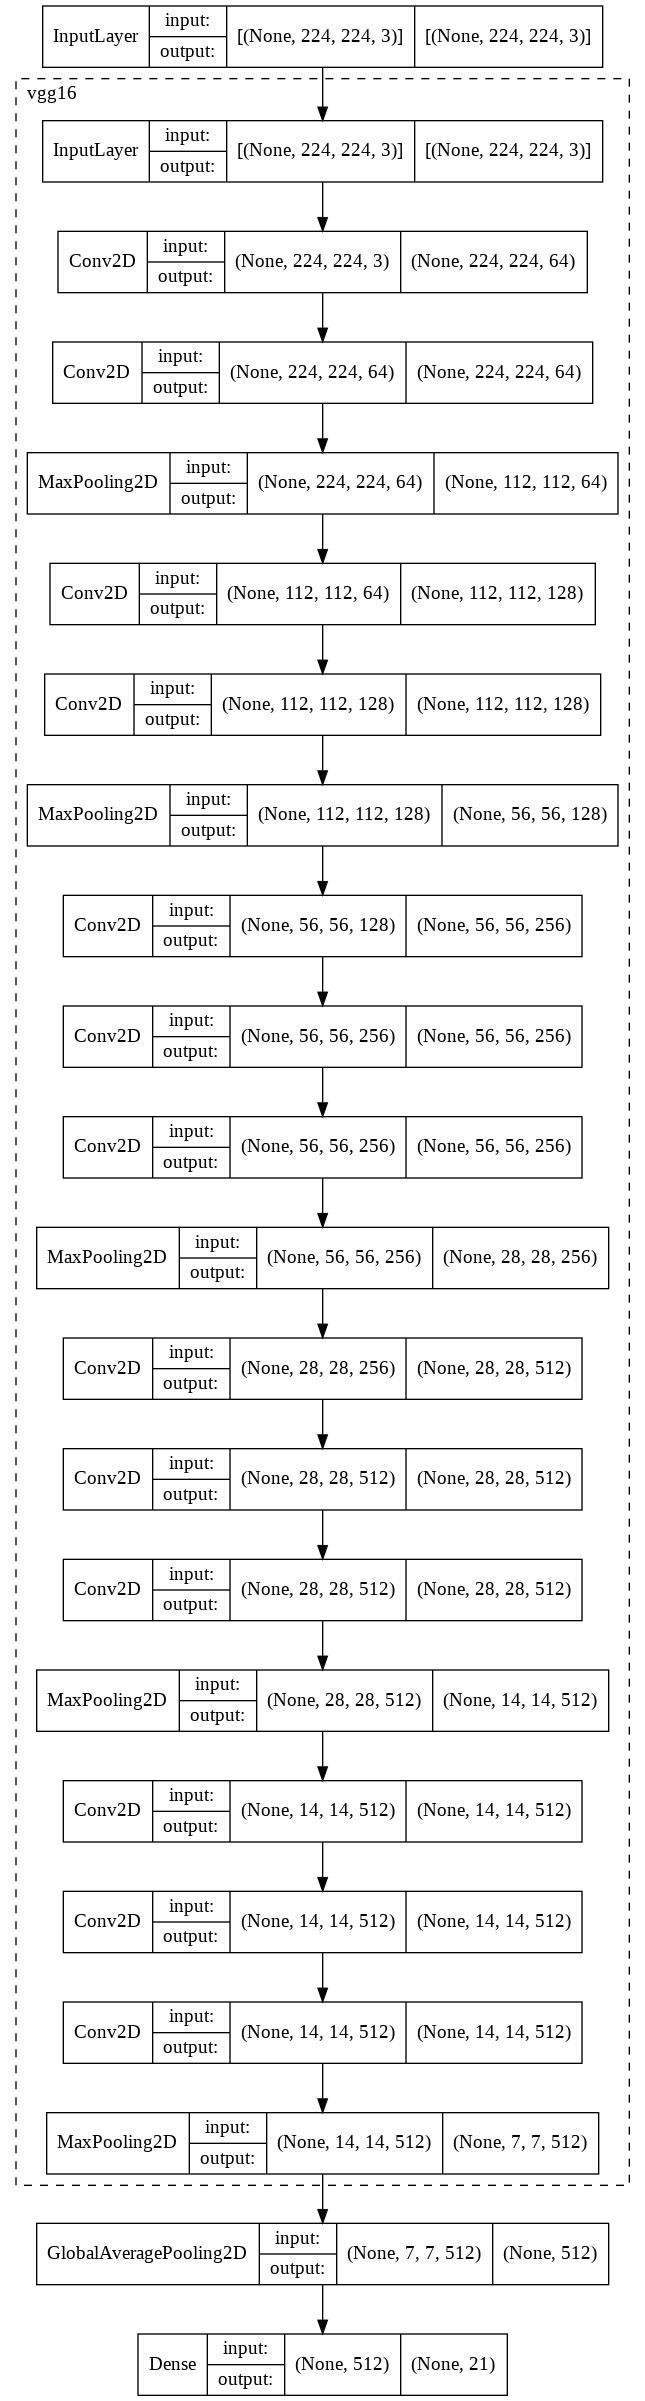

In [ ]:
model_name = 'Model_VGG16'
epochs = 10


def create_model_VGG16(shape, count_class):
    base_model = tf.keras.applications.VGG16(input_shape=shape,
                                             include_top=False,
                                             weights='imagenet')
    base_model.trainable = False

    inputs = tf.keras.Input(shape=shape)
    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(count_class, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

model_VGG16 = create_model_VGG16((img_height, img_width, 3), 21)
model_checkpoint_callback = get_checkpoint_callback(os.path.join(dir_google_drive, 'Models', model_name), epochs)


model_VGG16.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model_info(model_VGG16, scheme=True)

In [ ]:
model_VGG16.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10
230/230 [==============================] - 49s 206ms/step - loss: 2.0922 - accuracy: 0.5521 - val_loss: 0.7721 - val_accuracy: 0.7819
Epoch 2/10
230/230 [==============================] - 48s 204ms/step - loss: 0.4838 - accuracy: 0.8478 - val_loss: 0.4773 - val_accuracy: 0.8567
Epoch 3/10
230/230 [==============================] - 49s 210ms/step - loss: 0.2777 - accuracy: 0.9086 - val_loss: 0.3912 - val_accuracy: 0.8848
Epoch 4/10
230/230 [==============================] - 48s 205ms/step - loss: 0.1906 - accuracy: 0.9370 - val_loss: 0.3293 - val_accuracy: 0.8948
Epoch 5/10
230/230 [==============================] - 48s 205ms/step - loss: 0.1389 - accuracy: 0.9581 - val_loss: 0.3101 - val_accuracy: 0.9019
Epoch 6/10
230/230 [==============================] - 49s 210ms/step - loss: 0.1071 - accuracy: 0.9714 - val_loss: 0.2691 - val_accuracy: 0.9138
Epoch 7/10
230/230 [==============================] - 48s 205ms/step - loss: 0.0871 - accuracy: 0.9788 - val_loss: 0.2640 - val_ac

In [ ]:
history = model_VGG16.history.history
matrix = confusion_matrix(model_VGG16, test_ds)

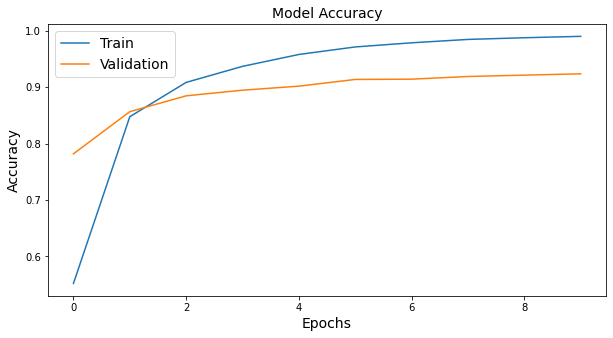

In [ ]:
draw_accuracy(history)

In [ ]:
model_name = 'Model_VGG16'
path = os.path.join(dir_google_drive, 'Models', f'{model_name} (epochs: {epochs})')
save_model(model_VGG16, history, path, matrix)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Neural Network/Models/Model_VGG16 (epochs: 10)/assets
<class 'numpy.ndarray'>


Model_VGG16:
Accuracy = 0.9171428571428571
Precision = 0.9171428571428573
Recall = 0.9235803580927859
F1 = 0.9203503507873169



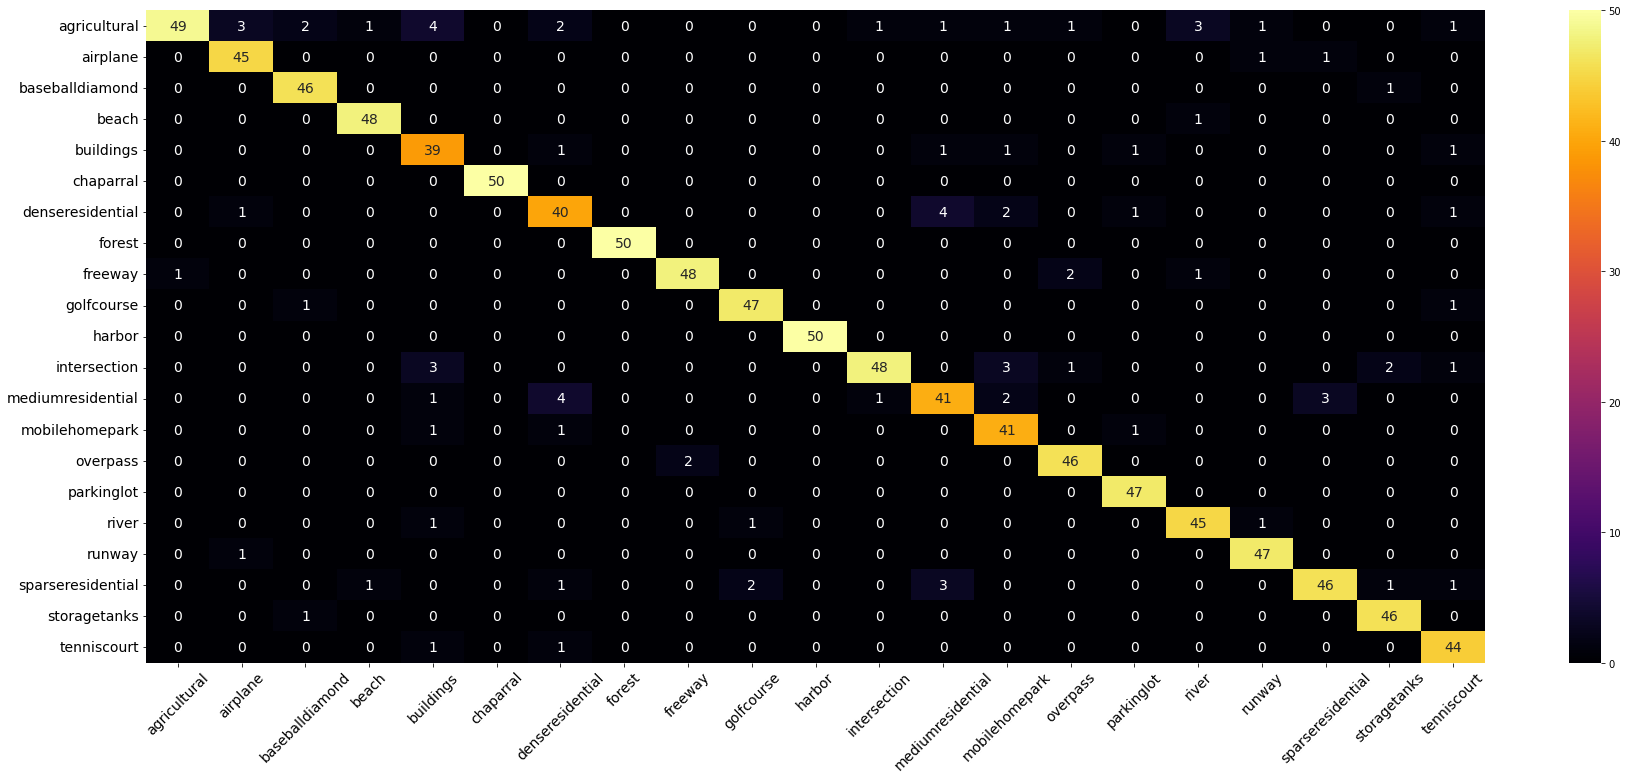

In [ ]:
accuracy = get_accuracy(matrix)
recall = get_precision(matrix)
precision = get_recall(matrix)
F1 = get_F(recall, precision, 1)
print(f"{model_name}:\nAccuracy = {accuracy}\nPrecision = {precision}\nRecall = {recall}\nF1 = {F1}\n")
draw_matrix(matrix,
            size=(30, 12),
            labels_x=test_ds.class_names,
            labels_y=test_ds.class_names)

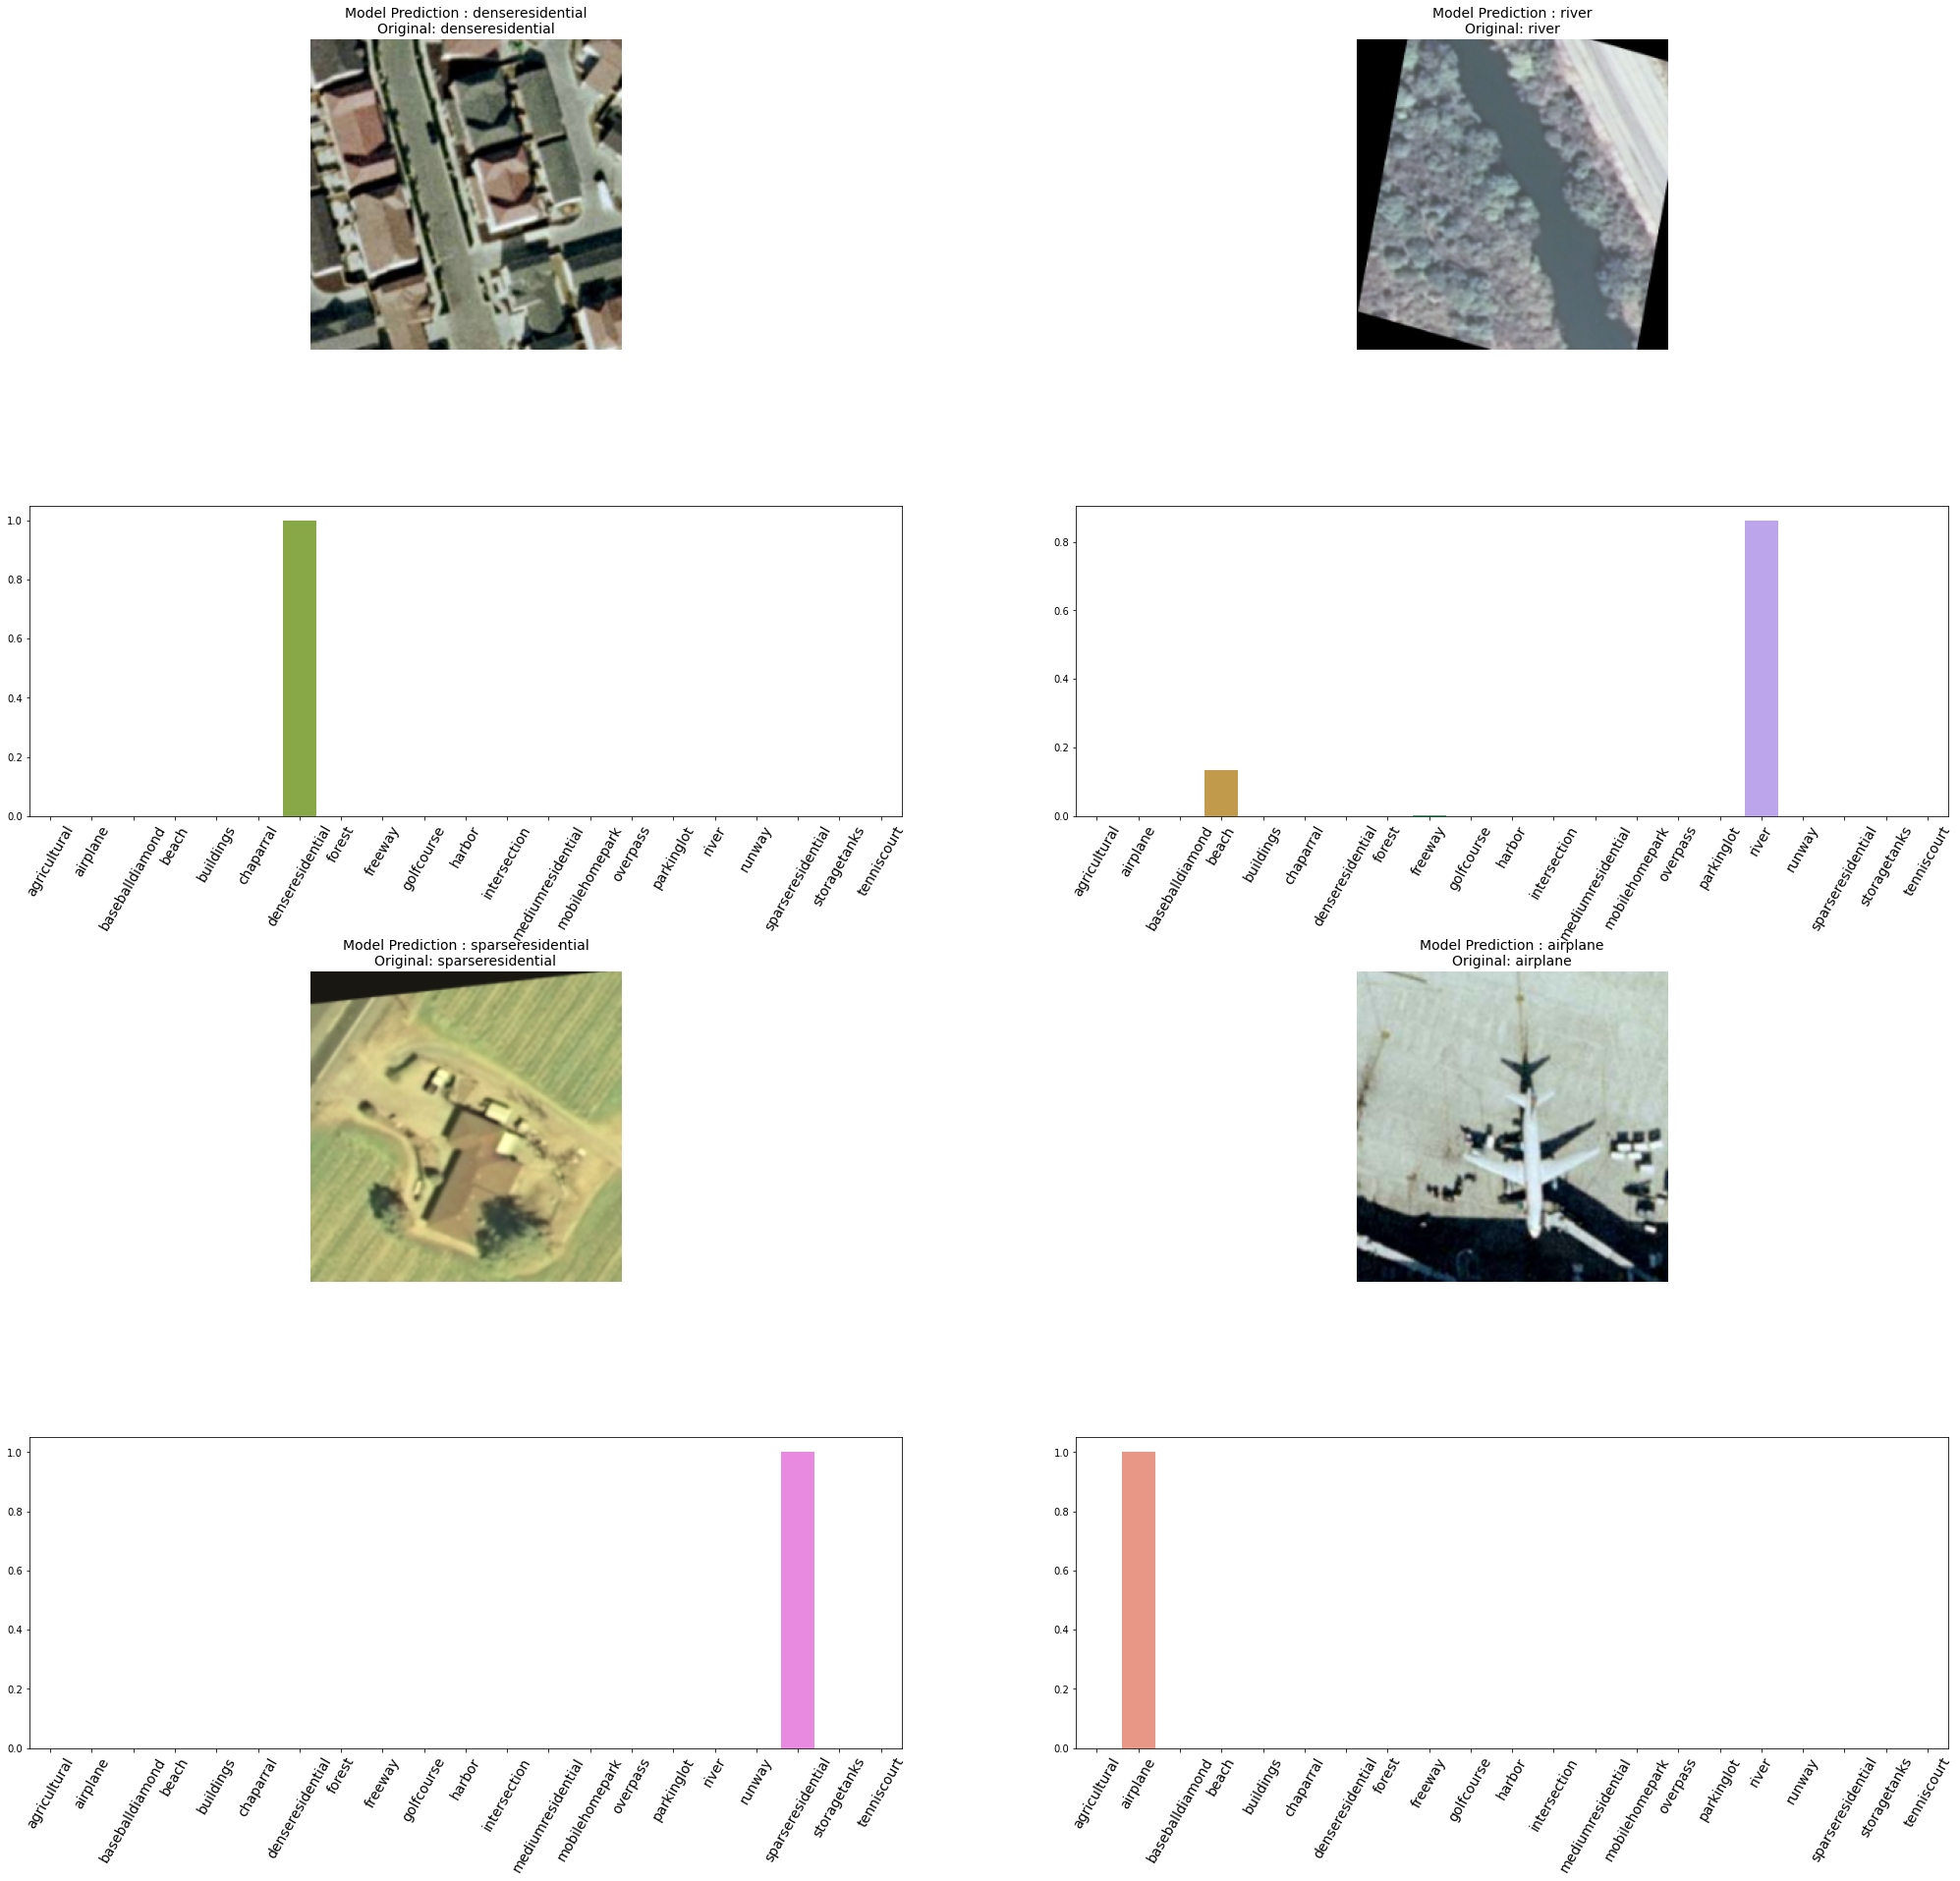

In [ ]:
plt.figure(figsize=(35,32))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
row, column = 2, 2
labels_name = test_ds.class_names

for image,label in test_ds.take(1):
  model_prediction = model_VGG16.predict(image)

  for i in range(row * column):
    plt.subplot(row * 2, column,(i%column +1) + 2 * (column) * int(i/column)) #
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(f"Model Prediction : {labels_name[tf.argmax(tf.round(model_prediction[i]))]}\nOriginal: {labels_name[tf.argmax(label[i])]}", fontsize =14)
    
    plt.axis("off")

    plt.subplot(row * 2, column,column + (i%column +1) + 2 * column * int(i/column))
    ax = sb.barplot(data=tf.abs(model_prediction[i]))
    ax.set_xticklabels(test_ds.class_names,
                        rotation=60, 
                        horizontalalignment='center',
                        fontsize=14
                        )

## EfficientNetB5

In [ ]:
model_name = 'Model_EfficientNetB5'
epochs = 10


def create_model_EfficientNetB5(shape, count_class):
    base_model = tf.keras.applications.EfficientNetB5(include_top = False)
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=shape)
    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(count_class, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)


model_EfficientNetB5 = create_model_EfficientNetB5((img_height,img_width,3), 21)
model_checkpoint_callback = get_checkpoint_callback(os.path.join(dir_google_drive, 'Models', model_name), epochs)


model_EfficientNetB5.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ['accuracy']
)

model_info(model_EfficientNetB5)

115277824/115263384 [==============================] - 3s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb5 (Functional)  (None, None, None, 2048)  28513527 
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 21)                43029     
                                                                 
Total params: 28,556,556
Trainable params: 43,029
Non-trainable params: 28,513,527
_________________________________________________________________


In [ ]:
model_EfficientNetB5.fit(
    train_ds,
    epochs = epochs,
    validation_data = valid_ds,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10
230/230 [==============================] - 89s 320ms/step - loss: 0.8612 - accuracy: 0.8208 - val_loss: 0.3853 - val_accuracy: 0.9105
Epoch 2/10
230/230 [==============================] - 67s 287ms/step - loss: 0.2894 - accuracy: 0.9370 - val_loss: 0.2572 - val_accuracy: 0.9371
Epoch 3/10
230/230 [==============================] - 68s 292ms/step - loss: 0.2008 - accuracy: 0.9547 - val_loss: 0.2025 - val_accuracy: 0.9490
Epoch 4/10
230/230 [==============================] - 67s 286ms/step - loss: 0.1552 - accuracy: 0.9673 - val_loss: 0.1742 - val_accuracy: 0.9533
Epoch 5/10
230/230 [==============================] - 68s 292ms/step - loss: 0.1198 - accuracy: 0.9763 - val_loss: 0.1526 - val_accuracy: 0.9557
Epoch 6/10
230/230 [==============================] - 68s 292ms/step - loss: 0.1009 - accuracy: 0.9797 - val_loss: 0.1378 - val_accuracy: 0.9610
Epoch 7/10
230/230 [==============================] - 67s 288ms/step - loss: 0.0866 - accuracy: 0.9834 - val_loss: 0.1237 - val_ac

In [ ]:
history = model_EfficientNetB5.history.history
matrix = confusion_matrix(model_EfficientNetB5, test_ds)

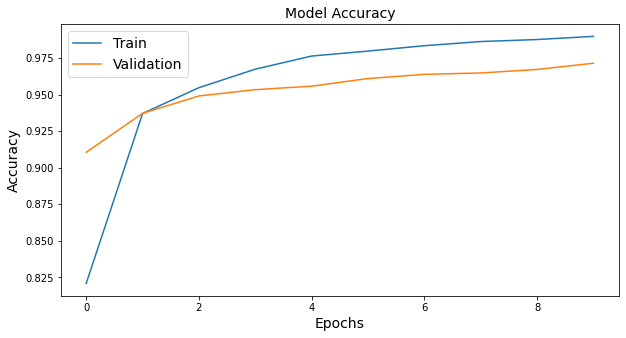

In [ ]:
draw_accuracy(history)

In [ ]:
model_name = 'Model_EfficientNetB5'

path = os.path.join(dir_google_drive, 'Models',f'{model_name} (epochs: {epochs})')
save_model(model_EfficientNetB5, history, path, matrix)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Neural Network/Models/Model_EfficientNetB5 (epochs: 10)/assets
<class 'numpy.ndarray'>


Model_EfficientNetB5:
Accuracy = 0.9657142857142857
Precision = 0.9657142857142857
Recall = 0.9702274856430868
F1 = 0.967965624938436



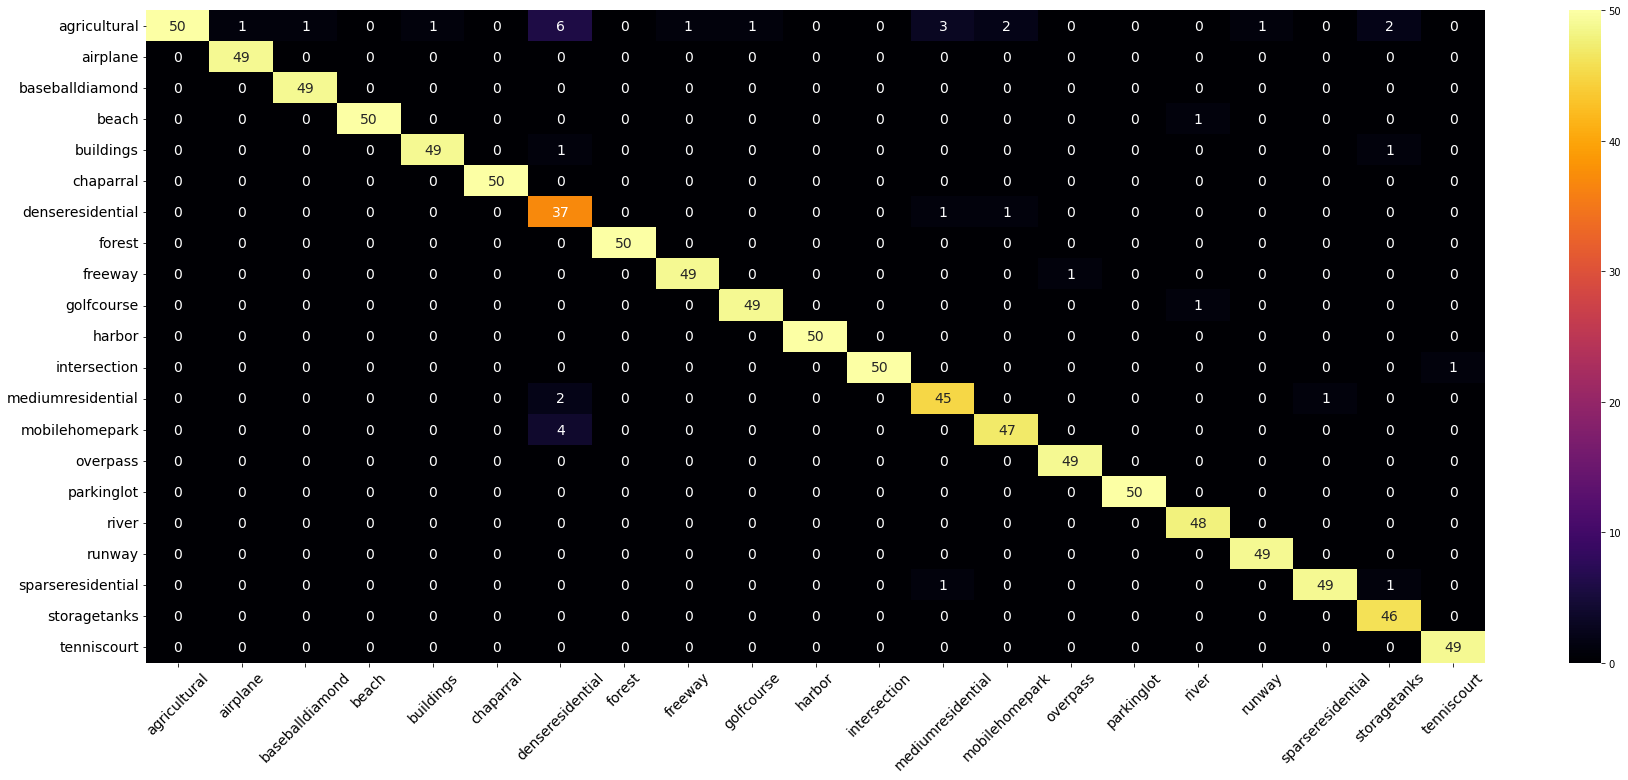

In [ ]:
accuracy = get_accuracy(matrix)
recall = get_precision(matrix)
precision = get_recall(matrix)
F1 = get_F(recall, precision, 1)
print(f"{model_name}:\nAccuracy = {accuracy}\nPrecision = {precision}\nRecall = {recall}\nF1 = {F1}\n")
draw_matrix(matrix, 
            size = (30, 12),
            labels_x = test_ds.class_names,
            labels_y = test_ds.class_names)

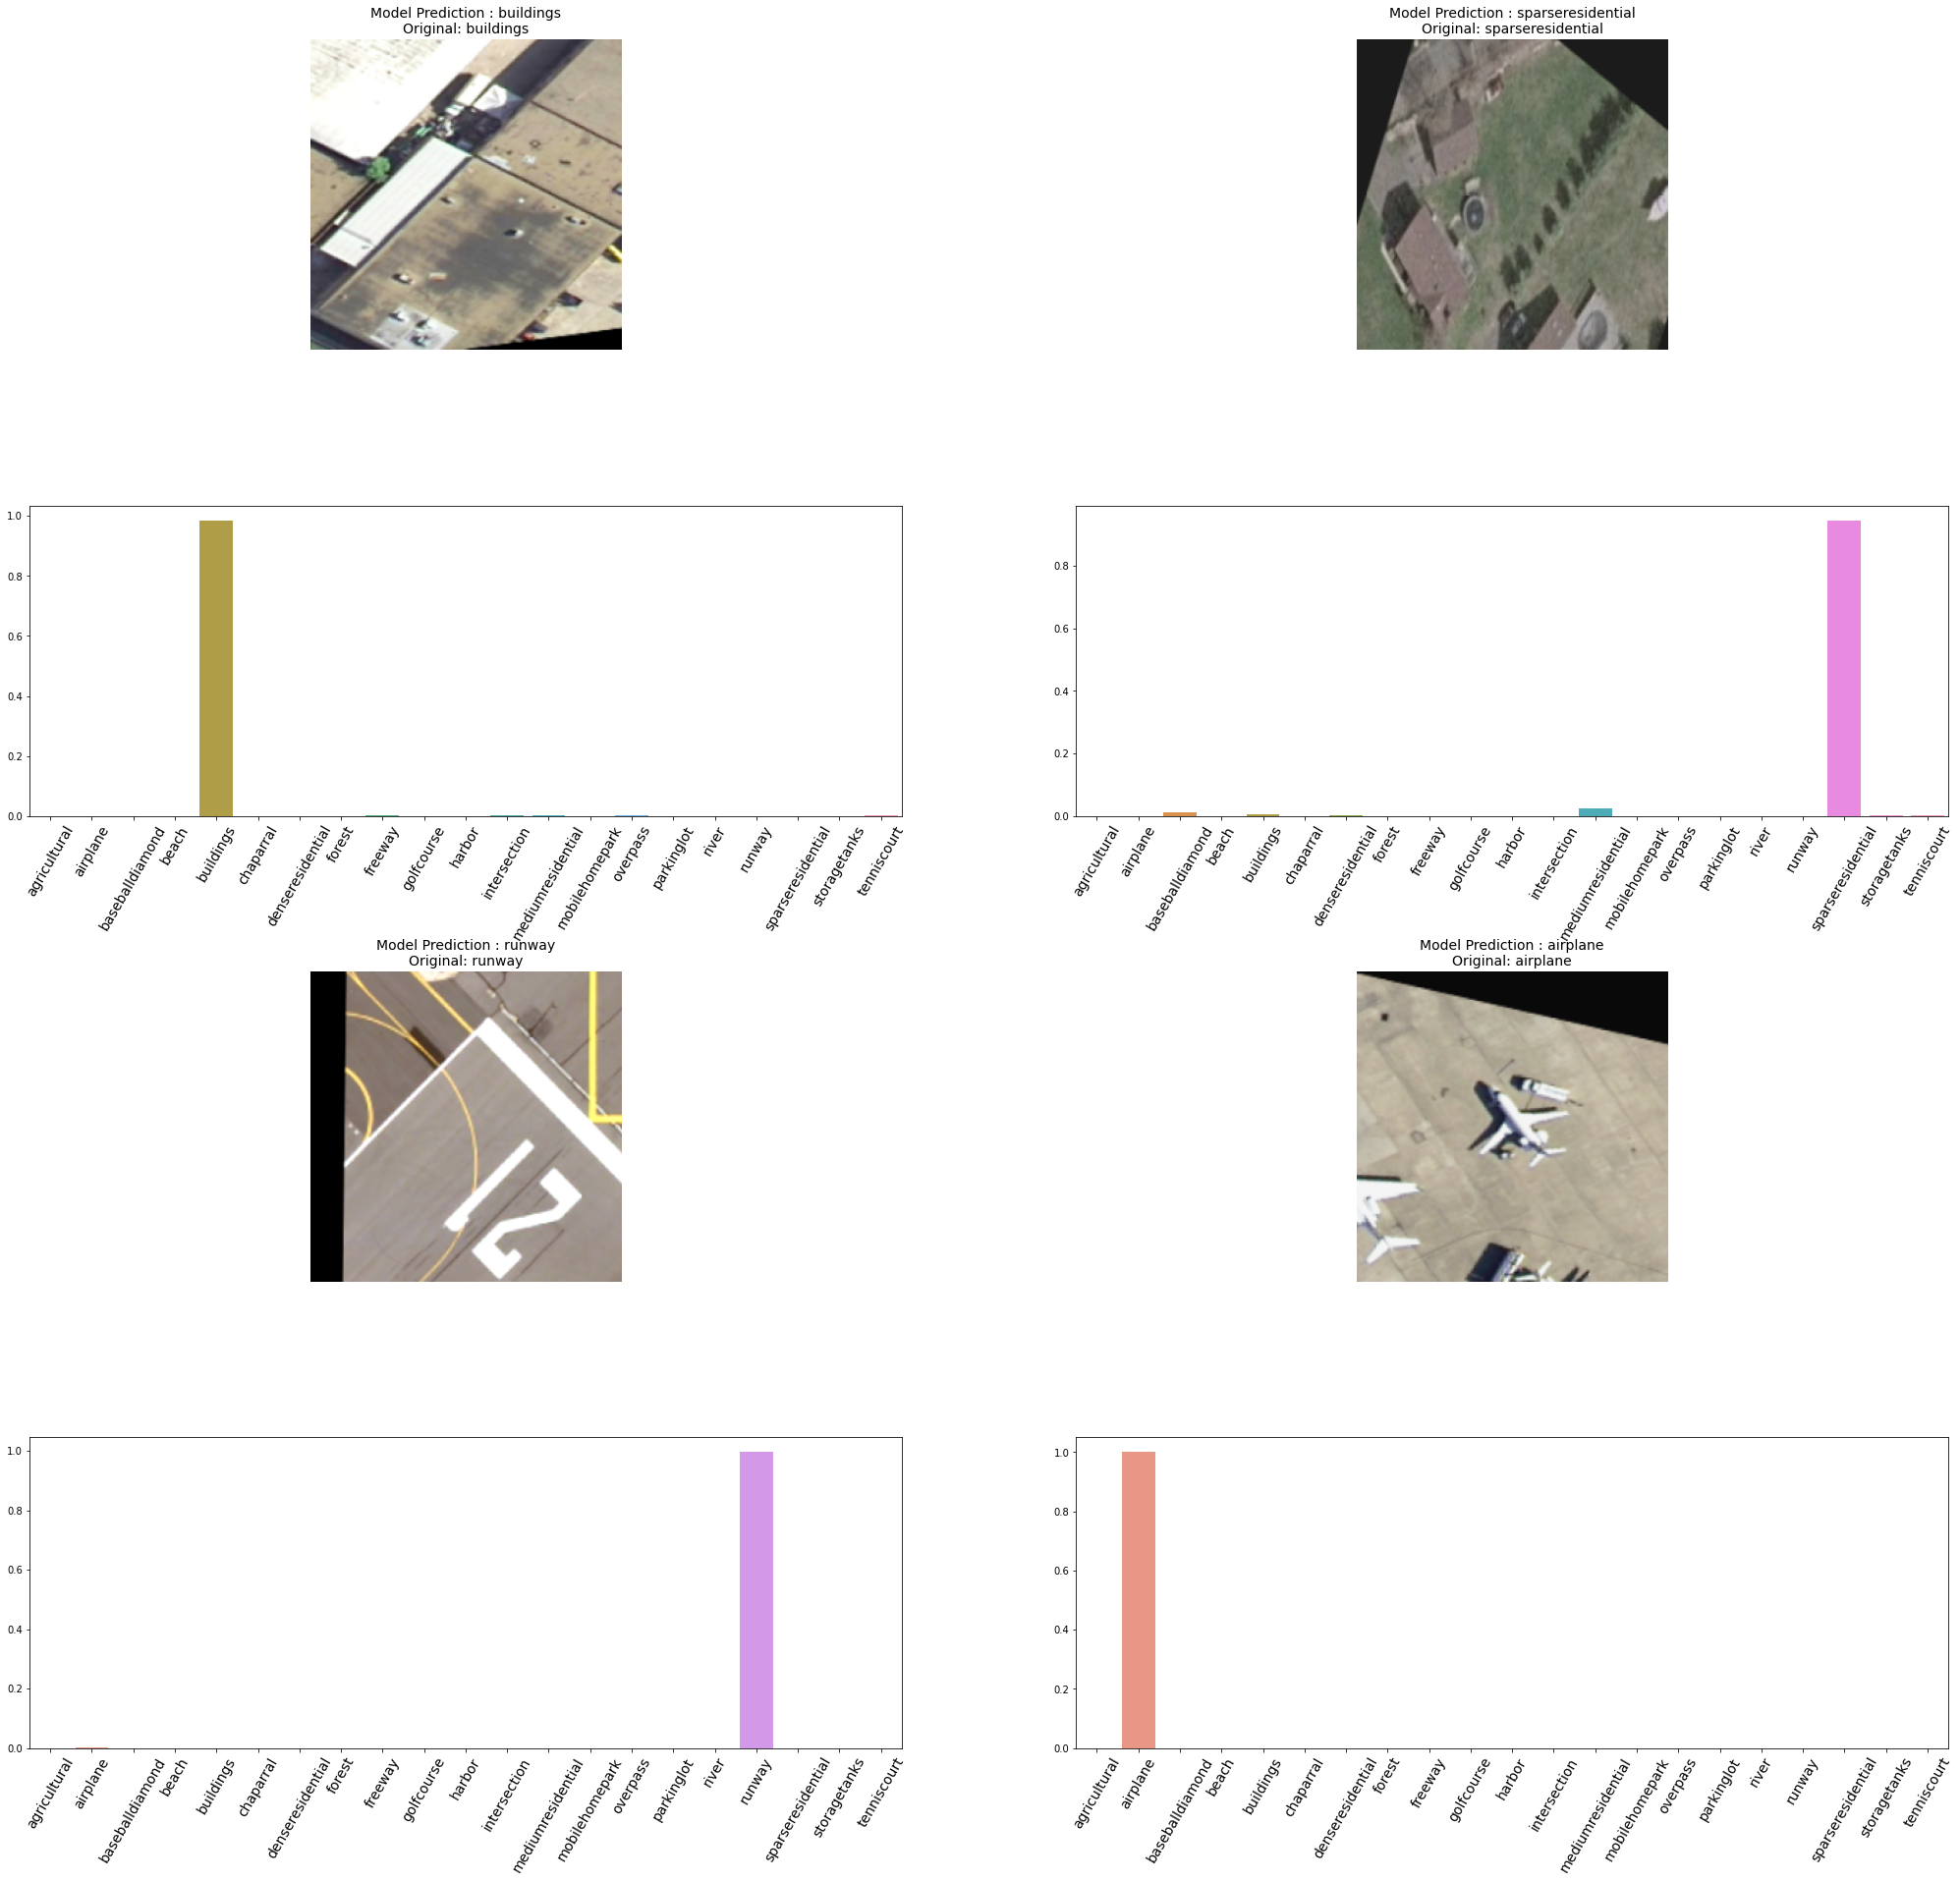

In [ ]:
plt.figure(figsize = (35,32))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
row, column = 2, 2
labels_name = test_ds.class_names

for image,label in test_ds.take(1):
  model_prediction = model_EfficientNetB5.predict(image)

  for i in range(row * column):
    plt.subplot(row * 2, column,(i%column +1) + 2 * (column) * int(i/column)) #
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(f"Model Prediction : {labels_name[tf.argmax(tf.round(model_prediction[i]))]}\nOriginal: {labels_name[tf.argmax(label[i])]}", fontsize =14)
    
    plt.axis("off")

    plt.subplot(row * 2, column,column + (i%column +1) + 2 * column * int(i/column))
    ax = sb.barplot(data=tf.abs(model_prediction[i]))
    ax.set_xticklabels(test_ds.class_names,
                        rotation = 60, 
                        horizontalalignment = 'center',
                        fontsize =14
                        )

## EfficientNetB7

In [ ]:
model_name = 'Model_EfficientNetB7'
epochs = 10


def create_model_EfficientNetB7(shape, count_class):
    base_model = tf.keras.applications.EfficientNetB7(include_top = False)
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=shape)
    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(count_class, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)


model_EfficientNetB7 = create_model_EfficientNetB7((img_height,img_width,3), 21)
model_checkpoint_callback = get_checkpoint_callback(os.path.join(dir_google_drive, 'Models', model_name), epochs)


model_EfficientNetB7.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ['accuracy']
)

model_info(model_EfficientNetB7)

258088960/258076736 [==============================] - 2s 0us/step
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb7 (Functional)  (None, None, None, 2560)  64097687 
                                                                 
 global_average_pooling2d_4   (None, 2560)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 21)                53781     
                                                                 
Total params: 64,151,468
Trainable params: 53,781
Non-trainable params: 64,097,687
_________________________________________________________________


In [ ]:
model_EfficientNetB7.fit(
    train_ds,
    epochs = epochs,
    validation_data = valid_ds,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10
230/230 [==============================] - 141s 509ms/step - loss: 0.8527 - accuracy: 0.8188 - val_loss: 0.3852 - val_accuracy: 0.9133
Epoch 2/10
230/230 [==============================] - 111s 478ms/step - loss: 0.3011 - accuracy: 0.9298 - val_loss: 0.2685 - val_accuracy: 0.9329
Epoch 3/10
230/230 [==============================] - 111s 480ms/step - loss: 0.2145 - accuracy: 0.9510 - val_loss: 0.2201 - val_accuracy: 0.9410
Epoch 4/10
230/230 [==============================] - 111s 478ms/step - loss: 0.1658 - accuracy: 0.9610 - val_loss: 0.1875 - val_accuracy: 0.9495
Epoch 5/10
230/230 [==============================] - 111s 479ms/step - loss: 0.1348 - accuracy: 0.9687 - val_loss: 0.1621 - val_accuracy: 0.9548
Epoch 6/10
230/230 [==============================] - 109s 472ms/step - loss: 0.1175 - accuracy: 0.9761 - val_loss: 0.1523 - val_accuracy: 0.9538
Epoch 7/10
230/230 [==============================] - 110s 477ms/step - loss: 0.1020 - accuracy: 0.9776 - val_loss: 0.1335 -

In [ ]:
history = model_EfficientNetB7.history.history
matrix = confusion_matrix(model_EfficientNetB7, test_ds)

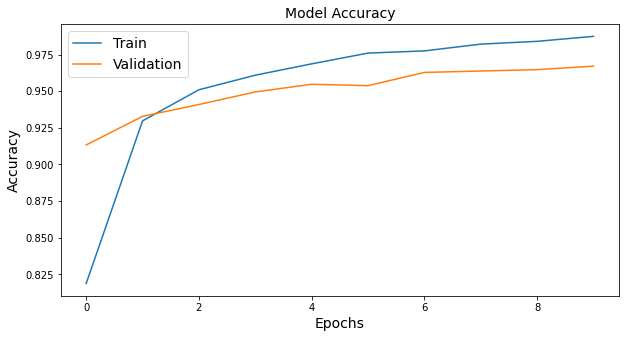

In [ ]:
draw_accuracy(history)

In [ ]:
model_name = 'Model_EfficientNetB7'

path = os.path.join(dir_google_drive, 'Models',f'{model_name} (epochs: {epochs})')
save_model(model_EfficientNetB7, history, path, matrix)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Neural Network/Models/Model_EfficientNetB7 (epochs: 10)/assets
<class 'numpy.ndarray'>


Model_EfficientNetB7:
Accuracy = 0.9171428571428571
Precision = 0.9171428571428573
Recall = 0.9235803580927859
F1 = 0.9203503507873169



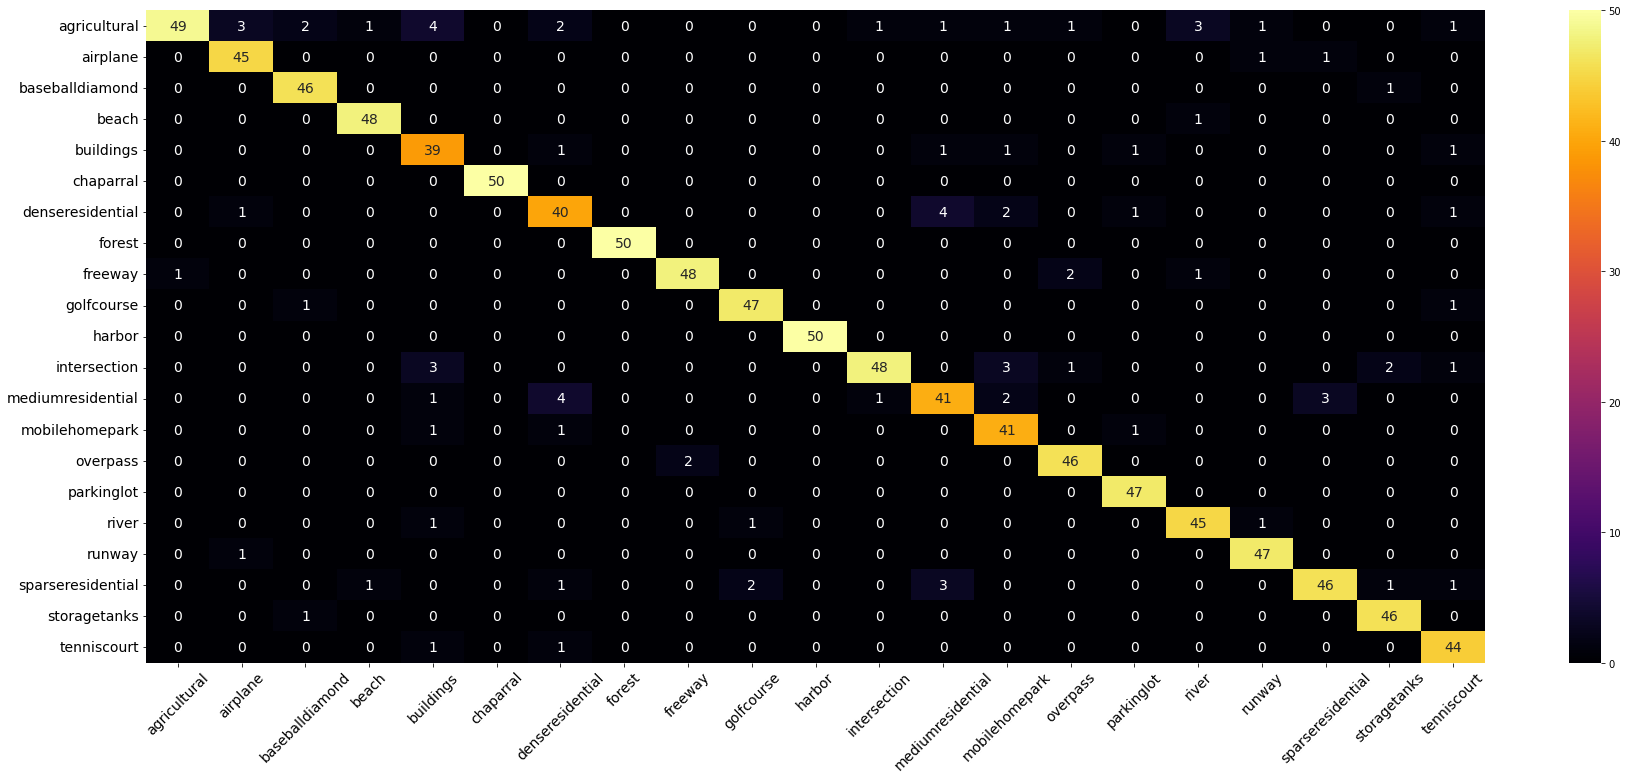

In [ ]:
accuracy = get_accuracy(matrix)
recall = get_precision(matrix)
precision = get_recall(matrix)
F1 = get_F(recall, precision, 1)
print(f"{model_name}:\nAccuracy = {accuracy}\nPrecision = {precision}\nRecall = {recall}\nF1 = {F1}\n")
draw_matrix(matrix, 
            size = (30, 12),
            labels_x = test_ds.class_names,
            labels_y = test_ds.class_names)

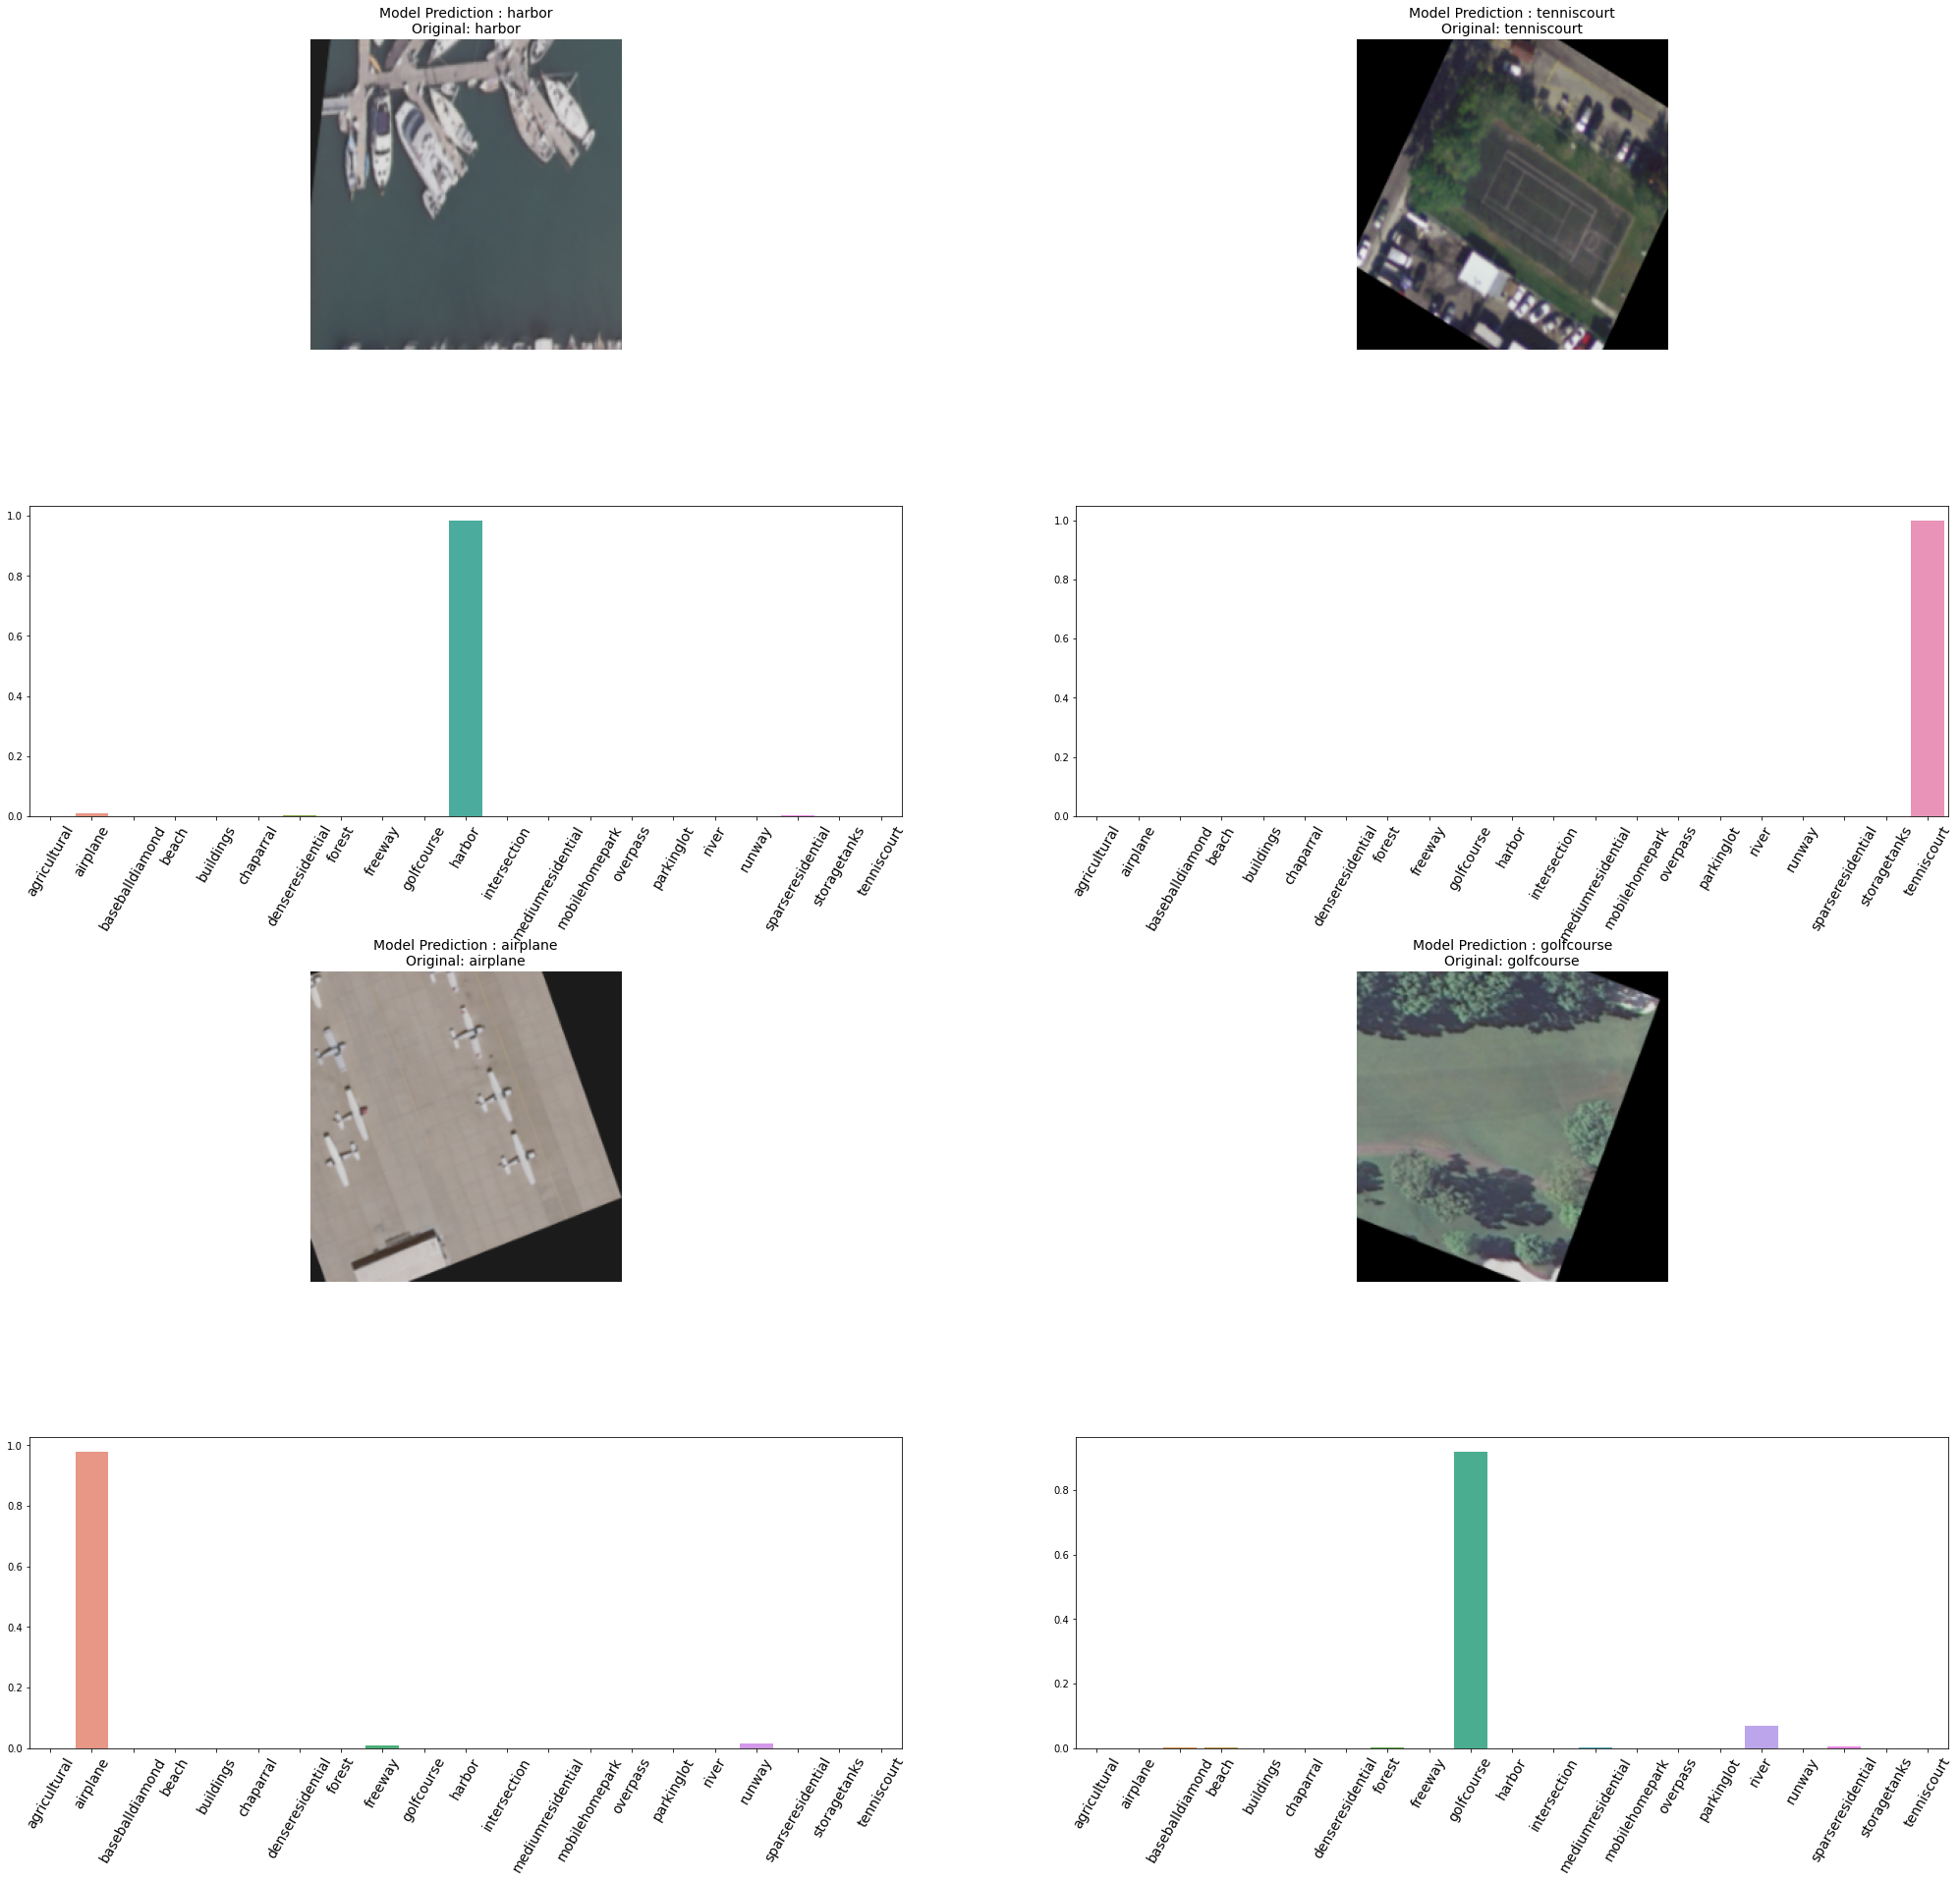

In [ ]:
plt.figure(figsize = (35,32))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
row, column = 2, 2
labels_name = test_ds.class_names

for image,label in test_ds.take(1):
  model_prediction = model_EfficientNetB7.predict(image)

  for i in range(row * column):
    plt.subplot(row * 2, column,(i%column +1) + 2 * (column) * int(i/column)) #
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(f"Model Prediction : {labels_name[tf.argmax(tf.round(model_prediction[i]))]}\nOriginal: {labels_name[tf.argmax(label[i])]}", fontsize =14)
    
    plt.axis("off")

    plt.subplot(row * 2, column,column + (i%column +1) + 2 * column * int(i/column))
    ax = sb.barplot(data=tf.abs(model_prediction[i]))
    ax.set_xticklabels(test_ds.class_names,
                        rotation = 60, 
                        horizontalalignment = 'center',
                        fontsize =14
                        )

## ResNet50

In [20]:
model_name = 'Model_ResNet50'
epochs = 10


def create_model_ResNet50(shape, count_class):
    base_model = tf.keras.applications.ResNet50(include_top = False)
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=shape)
    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(count_class, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)


model_ResNet50 = create_model_ResNet50((224,224,3), 21)
model_checkpoint_callback = get_checkpoint_callback(os.path.join(dir_google_drive, 'Models', model_name), epochs)


model_ResNet50.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ['accuracy']
)

model_info(model_ResNet50)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 21)                43029     
                                                                 
Total params: 23,630,741
Trainable params: 43,029
Non-trainable params: 23,587,712
_________________________________________________________________


In [21]:
model_ResNet50.fit(
    train_ds,
    epochs = epochs,
    validation_data = valid_ds,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10
230/230 [==============================] - 498s 2s/step - loss: 0.7131 - accuracy: 0.8007 - val_loss: 0.3103 - val_accuracy: 0.9167
Epoch 2/10
230/230 [==============================] - 38s 161ms/step - loss: 0.2067 - accuracy: 0.9476 - val_loss: 0.2209 - val_accuracy: 0.9400
Epoch 3/10
230/230 [==============================] - 38s 160ms/step - loss: 0.1292 - accuracy: 0.9736 - val_loss: 0.1804 - val_accuracy: 0.9467
Epoch 4/10
230/230 [==============================] - 37s 159ms/step - loss: 0.0910 - accuracy: 0.9839 - val_loss: 0.1551 - val_accuracy: 0.9514
Epoch 5/10
230/230 [==============================] - 38s 163ms/step - loss: 0.0707 - accuracy: 0.9879 - val_loss: 0.1411 - val_accuracy: 0.9538
Epoch 6/10
230/230 [==============================] - 38s 160ms/step - loss: 0.0514 - accuracy: 0.9939 - val_loss: 0.1323 - val_accuracy: 0.9571
Epoch 7/10
230/230 [==============================] - 38s 161ms/step - loss: 0.0411 - accuracy: 0.9952 - val_loss: 0.1173 - val_accu

In [22]:
history = model_ResNet50.history.history
matrix = confusion_matrix(model_ResNet50, test_ds)

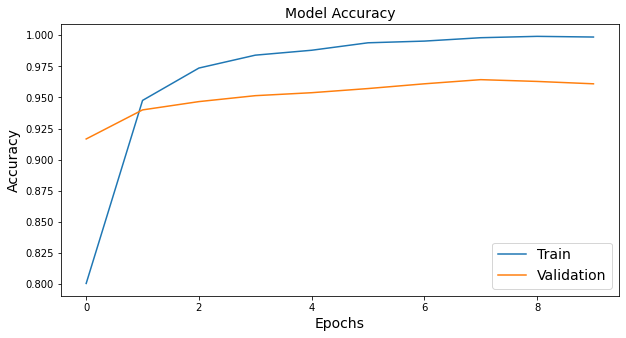

In [23]:
draw_accuracy(history)

In [26]:
model_name = 'Model_ResNet50'

path = os.path.join(dir_google_drive, 'Models',f'{model_name} (epochs: {epochs})')
save_model(model_ResNet50,history, path, matrix)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Neural Network/Models/Model_ResNet50 (epochs: 10)/assets
<class 'numpy.ndarray'>


Model_ResNet50:
Accuracy = 0.9476190476190476
Precision = 0.9476190476190477
Recall = 0.9528230740458796
F1 = 0.9502139356770215



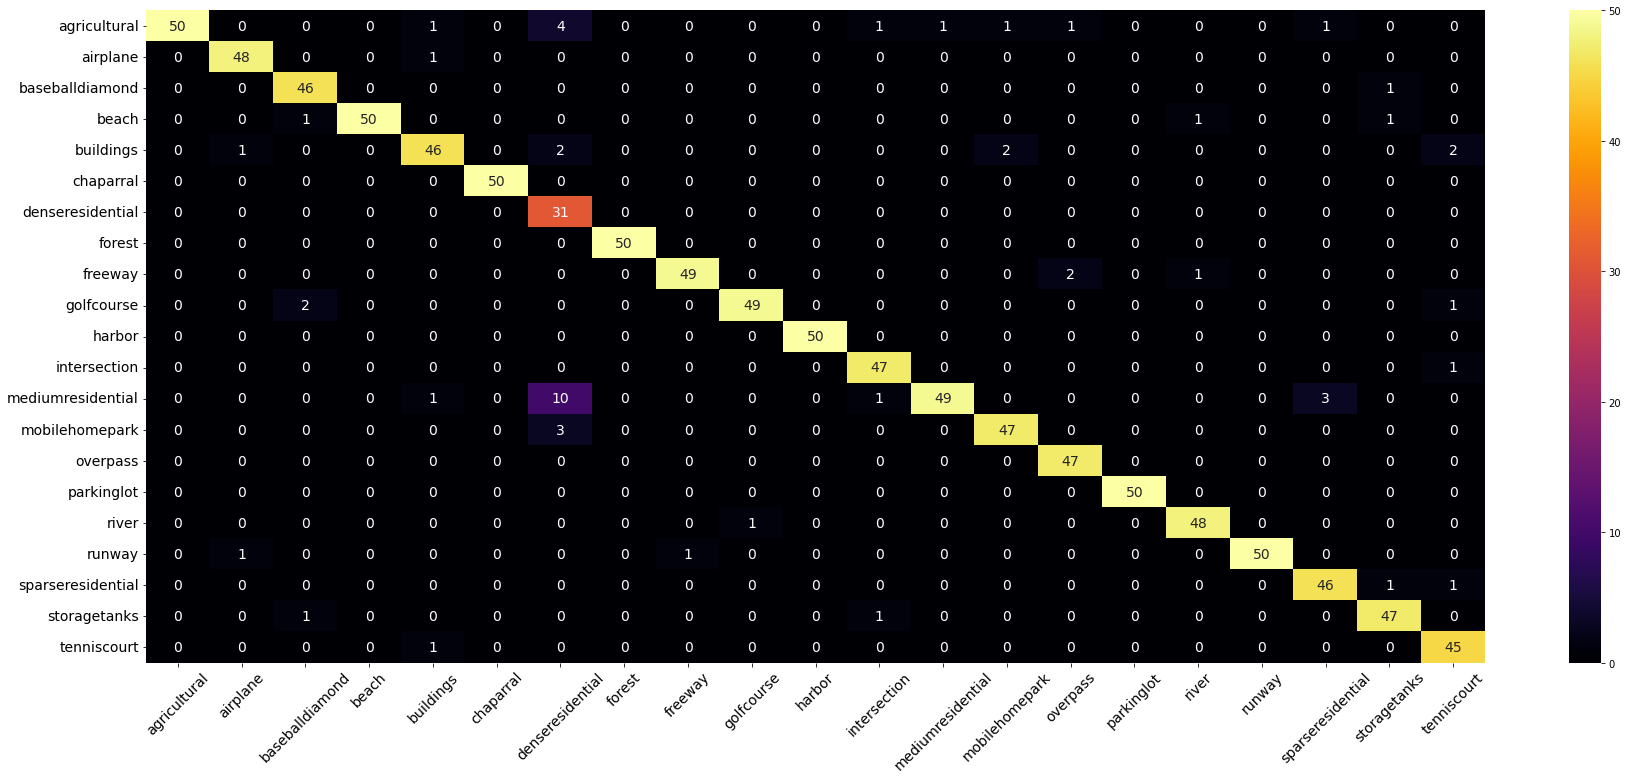

In [27]:
accuracy = get_accuracy(matrix)
recall = get_precision(matrix)
precision = get_recall(matrix)
F1 = get_F(recall, precision, 1)
print(f"{model_name}:\nAccuracy = {accuracy}\nPrecision = {precision}\nRecall = {recall}\nF1 = {F1}\n")
draw_matrix(matrix, 
            size = (30, 12),
            labels_x = test_ds.class_names,
            labels_y = test_ds.class_names)

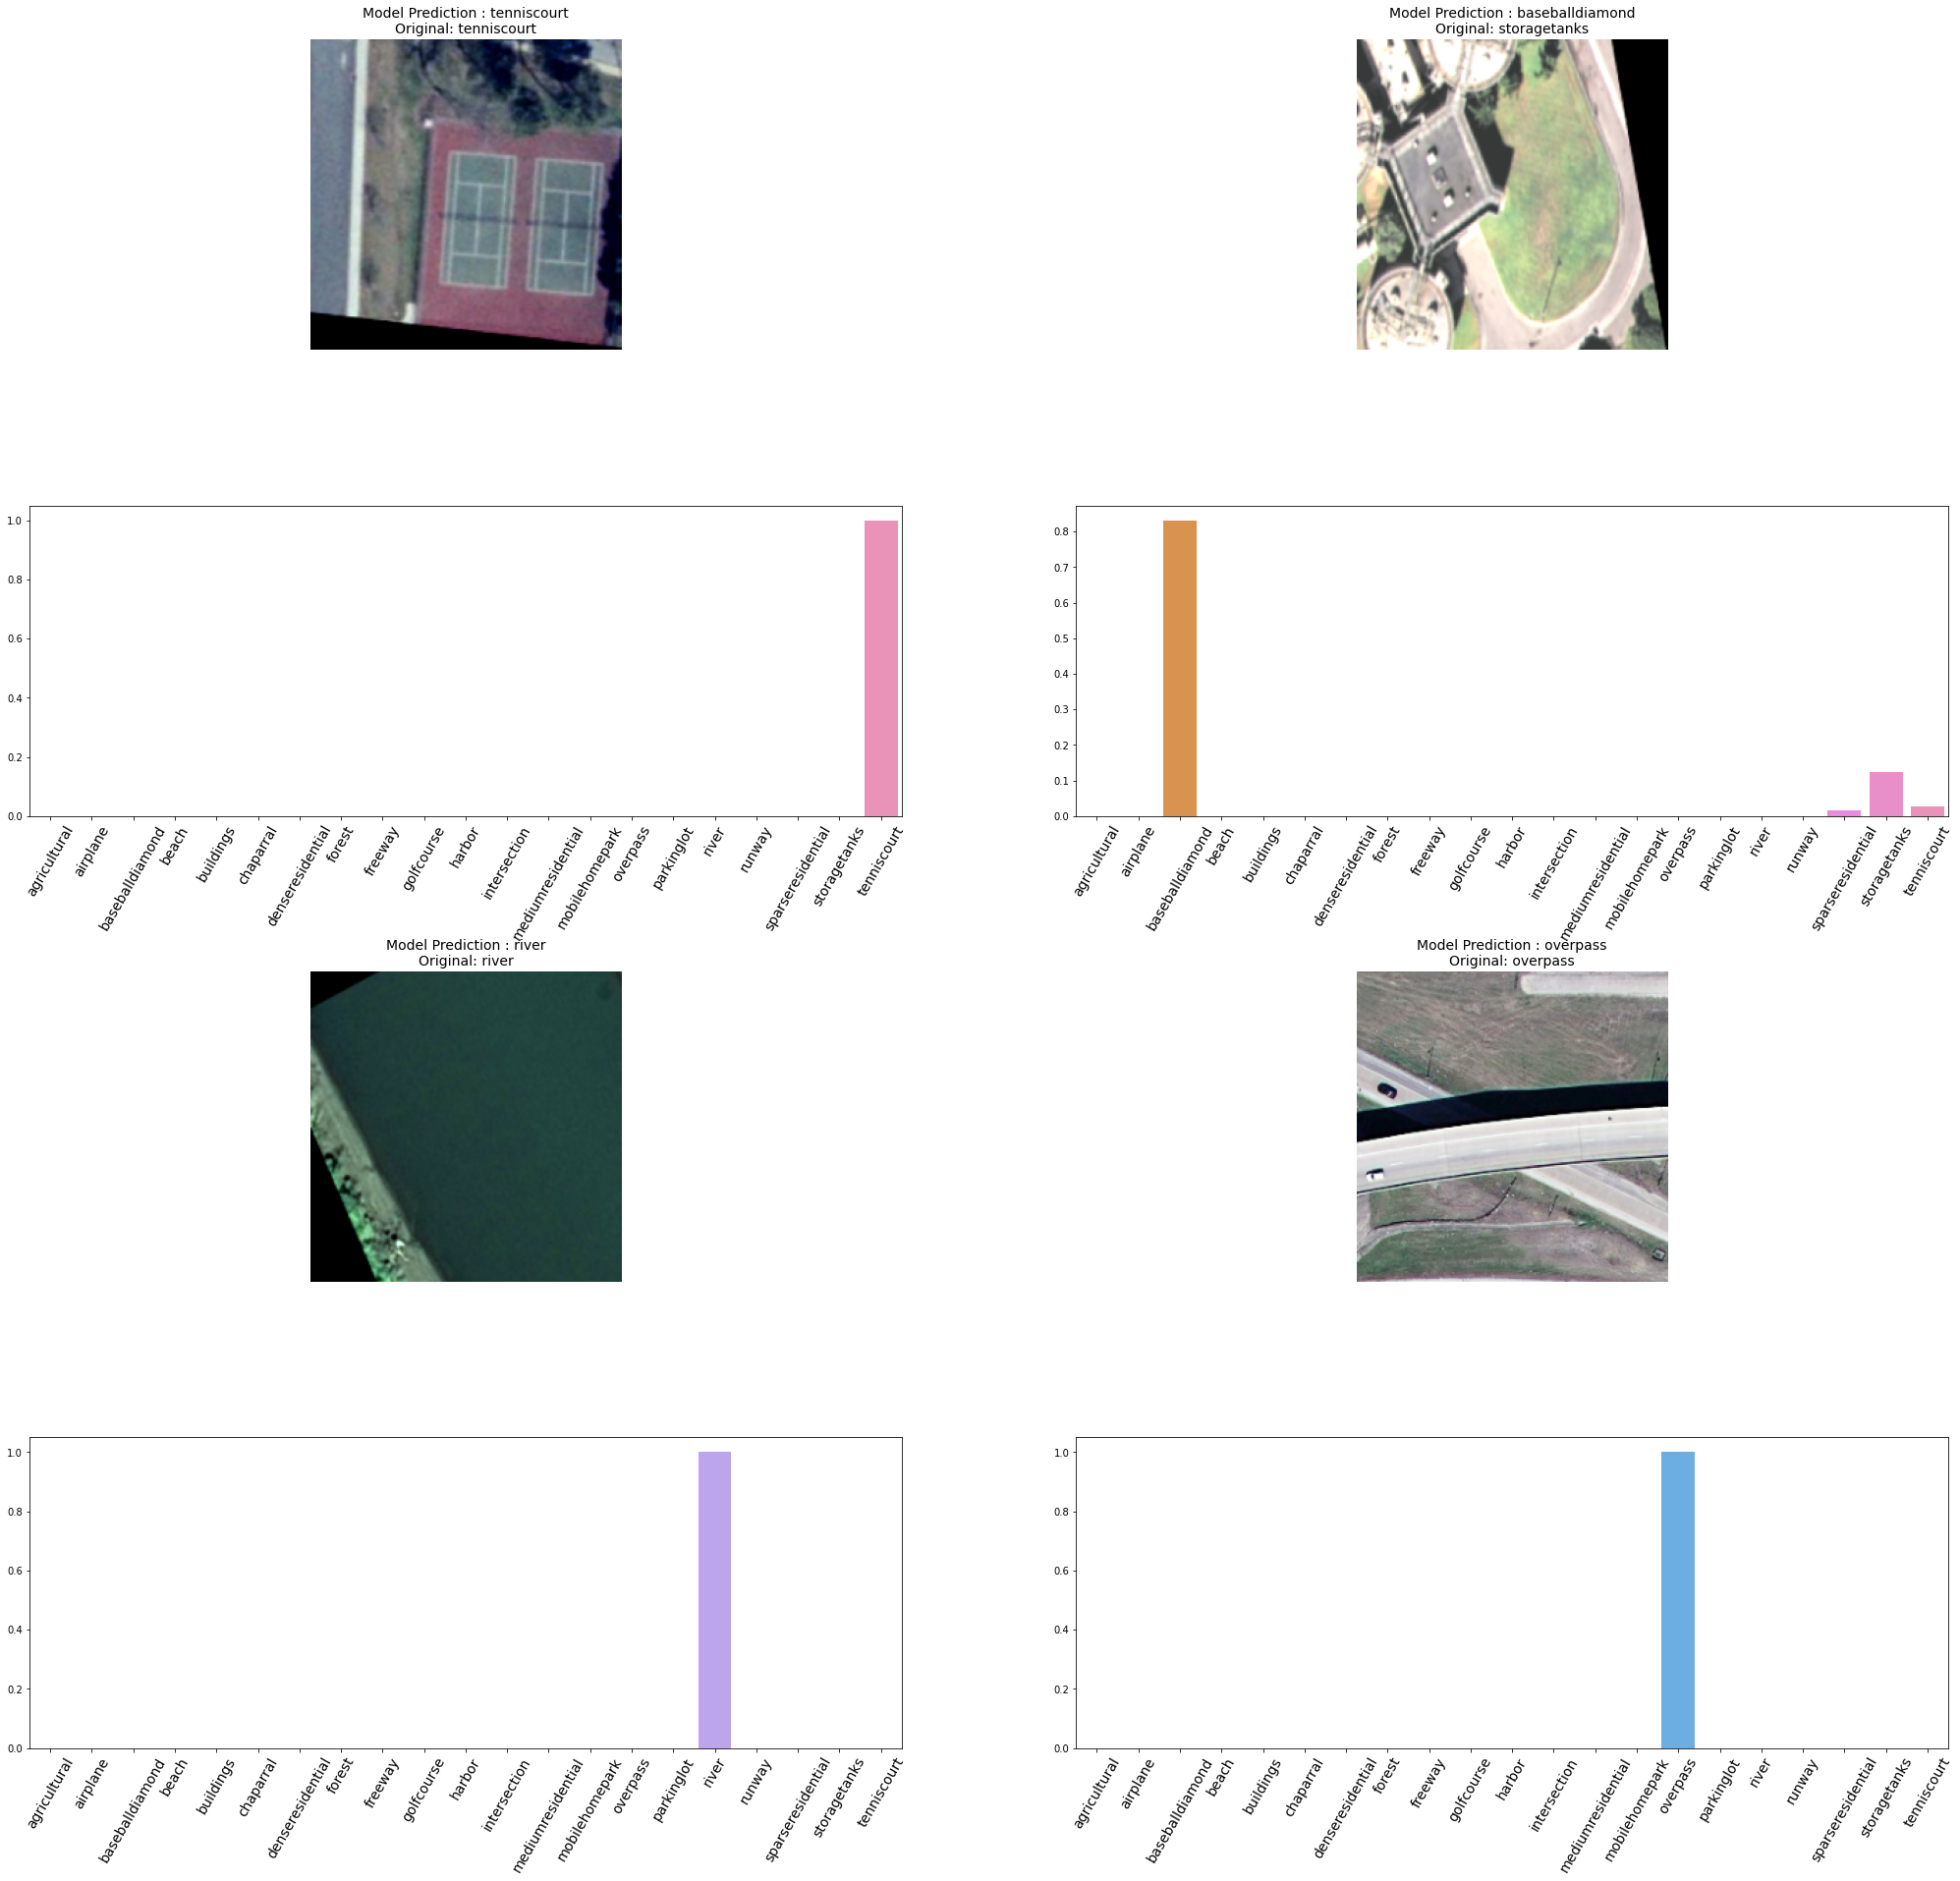

In [28]:
plt.figure(figsize = (35,32))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
row, column = 2, 2
labels_name = test_ds.class_names

for image,label in test_ds.take(1):
  model_prediction = model_ResNet50.predict(image)

  for i in range(row * column):
    plt.subplot(row * 2, column,(i%column +1) + 2 * (column) * int(i/column)) #
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(f"Model Prediction : {labels_name[tf.argmax(tf.round(model_prediction[i]))]}\nOriginal: {labels_name[tf.argmax(label[i])]}", fontsize =14)
    
    plt.axis("off")

    plt.subplot(row * 2, column,column + (i%column +1) + 2 * column * int(i/column))
    ax = sb.barplot(data=tf.abs(model_prediction[i]))
    ax.set_xticklabels(test_ds.class_names,
                        rotation = 60, 
                        horizontalalignment = 'center',
                        fontsize =14
                        )

# Сравнение моделей

In [20]:
model_name = ["Model_VGG16", "Model_ResNet50", "Model_EfficientNetB5", "Model_EfficientNetB7"]
epochs = 10
model_count = len(model_name)

matrix = []
accuracy = np.zeros(model_count)
recall = np.zeros(model_count)
precision = np.zeros(model_count)
F1 = np.zeros(model_count)

for i in range(model_count):
  _matrix = np.load(os.path.join(os.path.join(dir_google_drive, 'Models', f"{model_name[i]} (epochs: {epochs})"),'confusion_matrix.npy'),allow_pickle='TRUE')
  accuracy[i] = get_accuracy(_matrix)
  recall[i] = get_precision(_matrix)
  precision[i] = get_recall(_matrix)
  F1[i] = get_F(recall[i], precision[i], 1)
  matrix.append(_matrix)

In [21]:
for i in range(model_count):
  print(f"{model_name[i]}:\nAccuracy = {accuracy[i]}\nPrecision = {precision[i]}\nRecall = {recall[i]}\nF1 = {F1[i]}\n")

Model_VGG16:
Accuracy = 0.9171428571428571
Precision = 0.9171428571428573
Recall = 0.9235803580927859
F1 = 0.9203503507873169

Model_ResNet50:
Accuracy = 0.9476190476190476
Precision = 0.9476190476190477
Recall = 0.9528230740458796
F1 = 0.9502139356770215

Model_EfficientNetB5:
Accuracy = 0.9657142857142857
Precision = 0.9657142857142857
Recall = 0.9702274856430868
F1 = 0.967965624938436

Model_EfficientNetB7:
Accuracy = 0.9466666666666667
Precision = 0.9466666666666668
Recall = 0.955645547241702
F1 = 0.9511349168740831



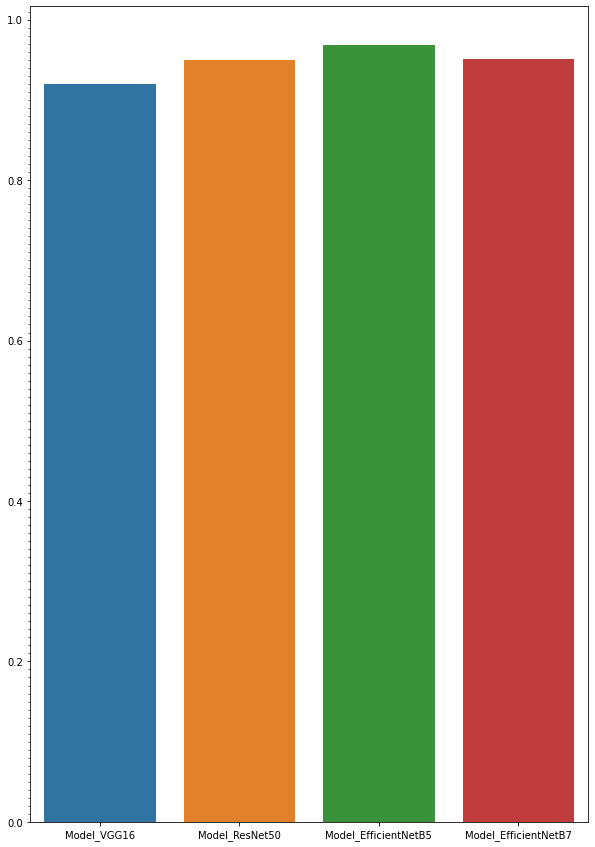

In [36]:
import matplotlib.ticker as ticker

plt.figure(figsize = (10,15))
ax = sb.barplot(y = F1, x = model_name)
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
plt.show()

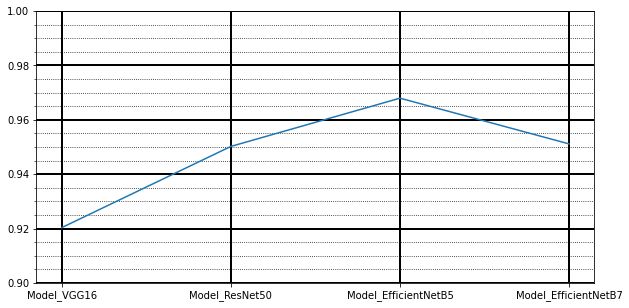

In [47]:
plt.figure(figsize = (10,5))
ax = sb.lineplot(y = F1, x = model_name)
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.005))

ax.grid(which='major',
        color = 'k', 
        linewidth = 2)

ax.grid(which='minor', 
        color = 'k', 
        linestyle = ':')

plt.ylim(0.9, 1)
plt.show()